In [ ]:
import os
import time
from basic_parameters import basic_params
from process import processing_and_save
timer = time.time()
os.system("mpiexec -n 6 python3 base_model.py")
print("Simulation is finished!")
print(time.time() - timer)

file = basic_params["file_results"]
processing_and_save(file)


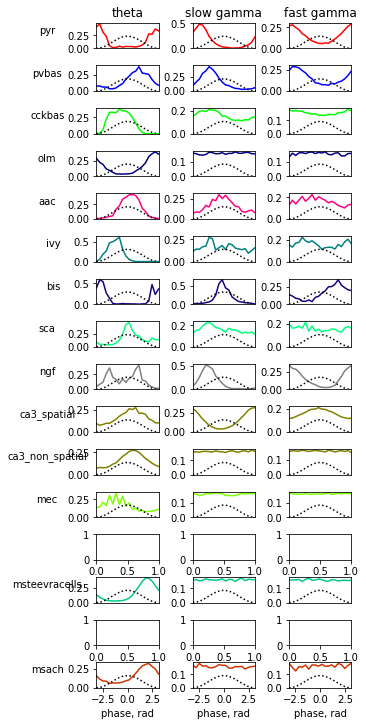

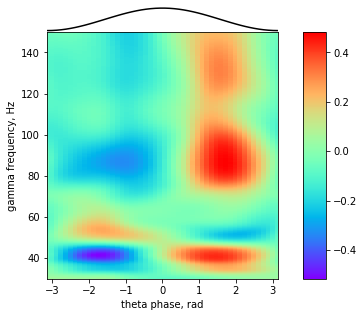

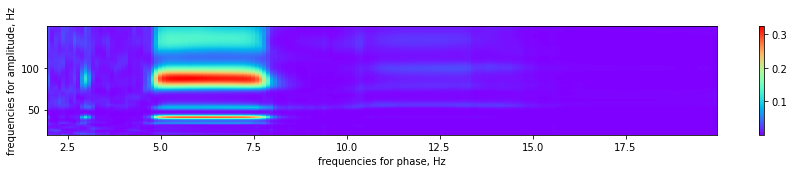

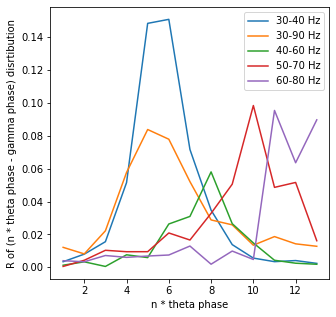

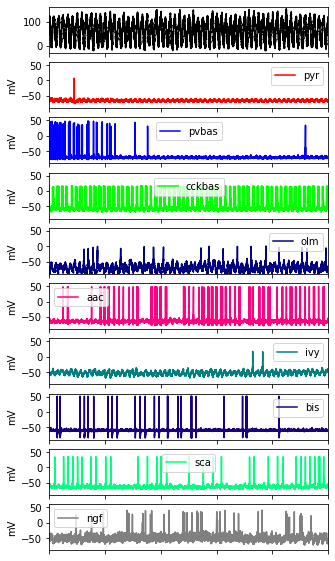

In [19]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15, 2)
# from basic_parameters import basic_params
import plot_result as my_plot

filepath = "../../Data/CA1_simulation/test.hdf5" #  basic_params["file_results"]
# my_plot.plot_v(filepath)

#my_plot.plot_spike_raster(filepath)
# my_plot.plot_lfp(filepath)
my_plot.plot_phase_disrtibution(filepath)
my_plot.plot_phase_by_amplitude_coupling(filepath)
# my_plot.plot_current_source_density(filepath, "theta")
my_plot.plot_modulation_index(filepath)
my_plot.plot_nm_phase_phase_coupling(filepath)
my_plot.plot_v_vs_pyr_lfp(filepath)
# my_plot.plot_phase_precession(filepath)

In [ ]:
from process import processing_and_save

file = "../../Data/CA1_simulation/test.hdf5"
processing_and_save(file)



/usr/local/lib/python3.8/dist-packages/elephant/pandas_bridge.py:21: DeprecationWarning: pandas_bridge module will be removed in Elephant v0.8.x
  warnings.warn("pandas_bridge module will be removed in Elephant v0.8.x",


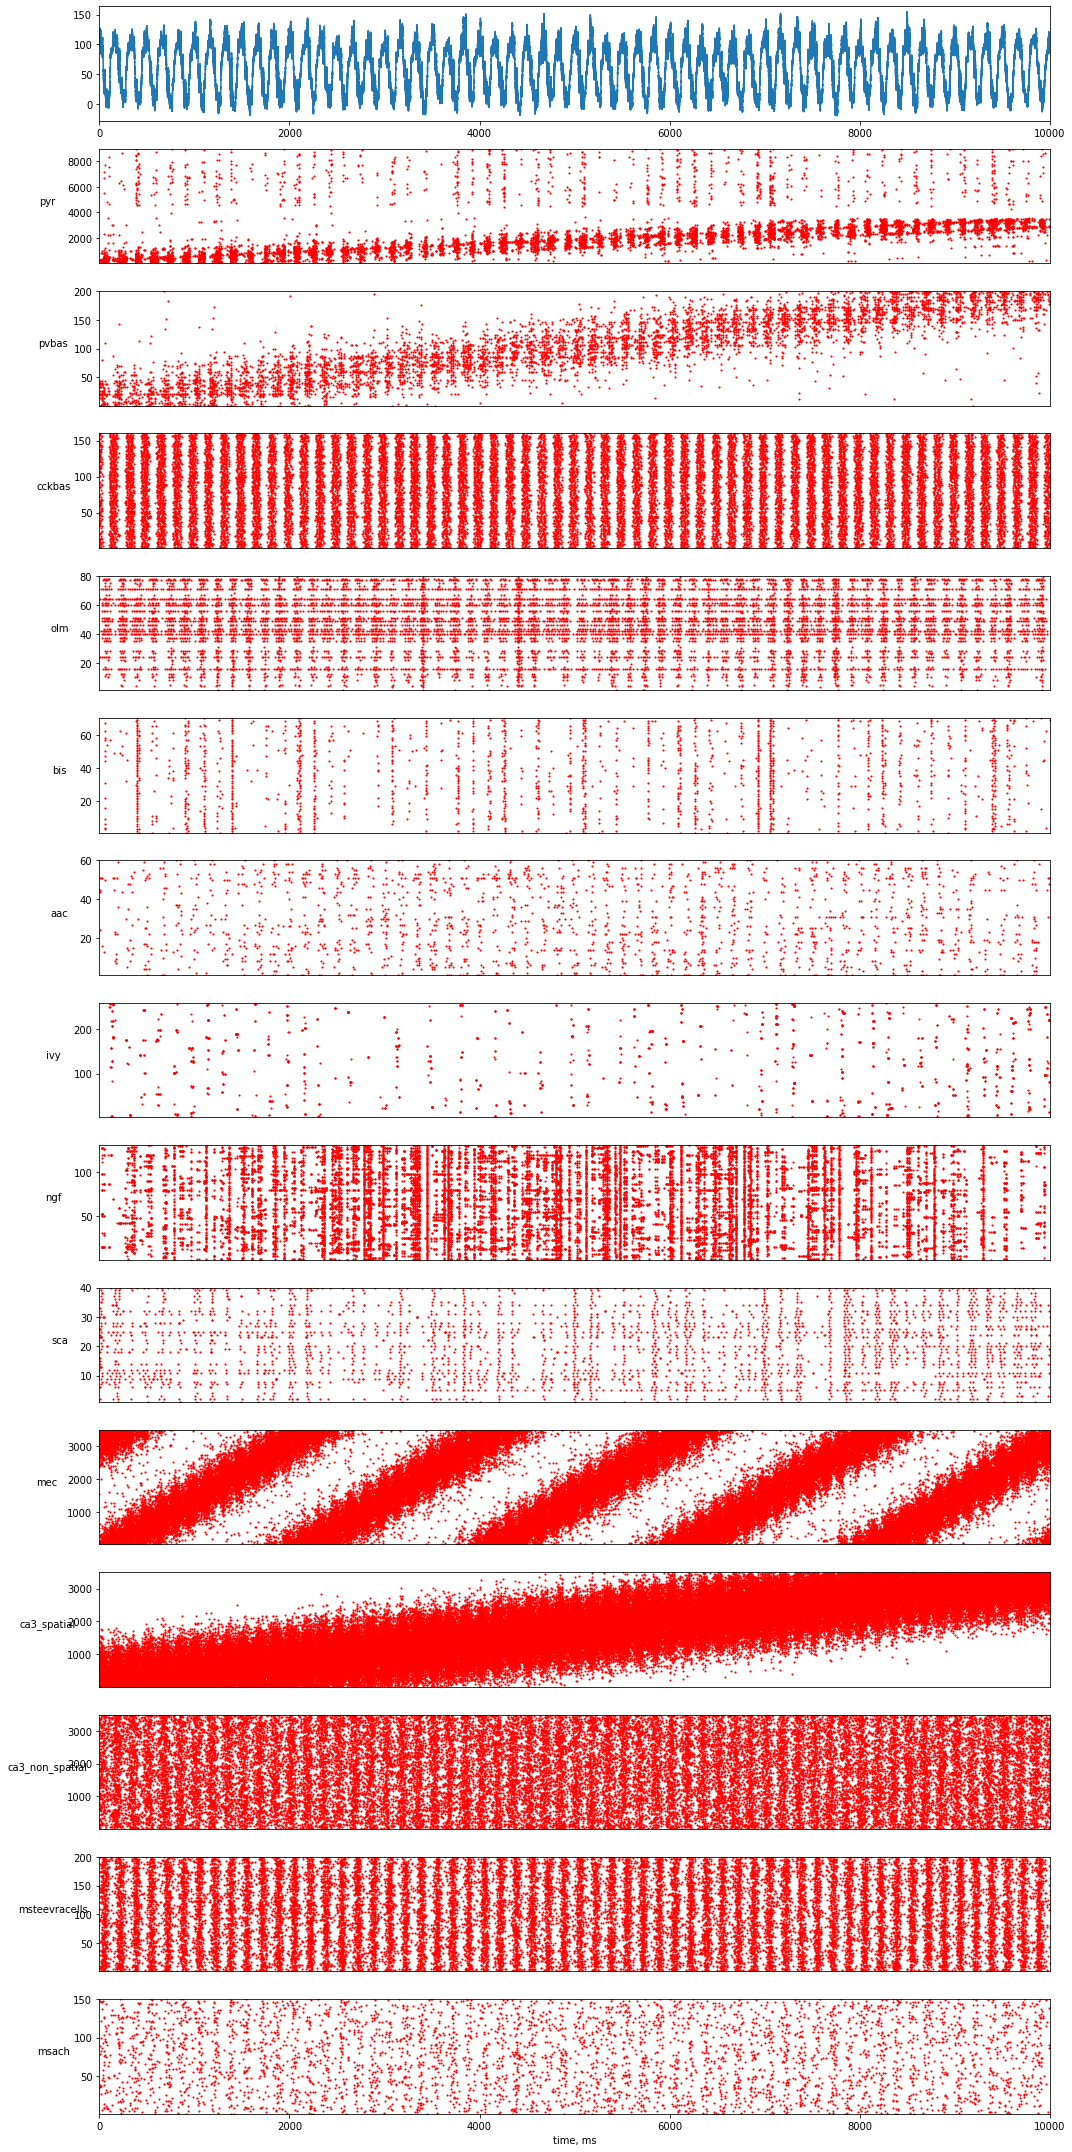

In [20]:
import numpy as np
# from scipy.signal import hilbert
import matplotlib.pyplot as plt
from matplotlib import gridspec
import h5py
# from basic_parameters import basic_params
# import processingLib as proclib
plt.rcParams["figure.figsize"] = (15, 2)

# import plot_result as my_plot
neuron_order = ["pyr", "pvbas", "cckbas", "olm", "bis", "aac", "ivy", "ngf", "sca", "mec", "ca3_spatial", "ca3_non_spatial", "msteevracells", "msach"]

# neuron_order = ["pvbas", "ca3_spatial"]

filepath = "../../Data/CA1_simulation/test.hdf5"   # basic_params["file_results"]
# my_plot.plot_spike_raster(file)

with h5py.File(filepath, 'r') as h5file:
    t0 = h5file["time"][0]
    t1 = h5file["time"][-1]
    
    lfp = h5file["extracellular/electrode_1/lfp/origin_data/channel_1"][:]
    t = np.linspace(t0, t1, lfp.size)
   
    raster_group = h5file["extracellular/electrode_1/firing/origin_data"]
                
    fig = plt.figure(figsize=(15, 30))
        
    neurons_num = len(neuron_order)
    gs = gridspec.GridSpec(neurons_num+1, 1)
    
    axes = plt.subplot(gs[0])
    axes.plot(t, lfp)
    axes.set_xlim(t0, t1)

    for celltype_idx, celltype in enumerate(neuron_order):
   
        try:
            celltype_group = raster_group[celltype]
            axes = plt.subplot(gs[celltype_idx+1])
           
            for sp_idx, (cell_key, firing) in enumerate(celltype_group.items()):
                sp_idx += 1
                axes.scatter(firing,  np.zeros(firing.size) + sp_idx, s=1.2, color="red" )

            axes.set_ylim(1, sp_idx)
            axes.set_xlim(t0, t1)
            axes.set_ylabel(celltype, rotation='horizontal', labelpad=20)

            if celltype_idx == len(neuron_order) - 1:
                axes.set_xlabel("time, ms")
            else:
                axes.tick_params(labelbottom=False, bottom=False)
        except KeyError:
            continue
            
            
fig.tight_layout()
plt.show()

In [ ]:
print("hello")

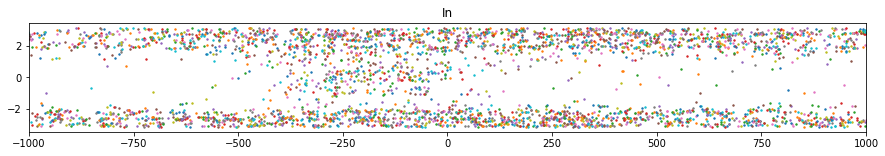

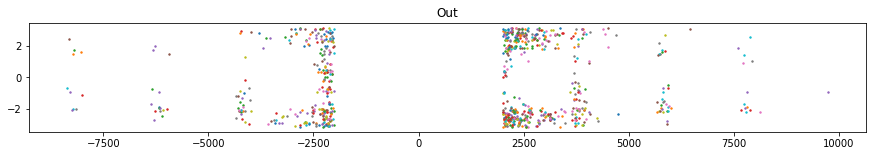

In [22]:
import numpy as np
from scipy.signal import hilbert
import matplotlib.pyplot as plt
import h5py

filepath = "../../Data/CA1_simulation/test.hdf5" 

with h5py.File(filepath, 'r') as h5file:
    sampling_rate = h5file["extracellular/electrode_1/lfp/origin_data"].attrs["SamplingRate"]
    theta_signal = h5file["extracellular/electrode_1/lfp/processing/bands/channel_1/theta"][:]
    t = h5file["time"][:]
    
    theta_phases = np.angle( hilbert(theta_signal) ) #  2*np.pi*0.005*t    # 
    # theta_phases = theta_phases%(2*np.pi)
    # theta_phases[theta_phases>np.pi] -= 2*np.pi
    theta_signal = np.cos(theta_phases)
    
    #plt.plot(t, theta_phases)
    
    Npyr = 9000
    pyr_coord_x = np.cumsum( np.zeros(Npyr) + 3 ) # np.zeros(Npyr) + 1500   # 
    pyr_coord_x[pyr_coord_x.size//2:] = np.nan 
    
    
    
    firing_group = h5file["extracellular/electrode_1/firing/origin_data/pyr"] # pyr !!!!
    sampling_rate *= 0.001

    fig_in, ax_in = plt.subplots()
    fig_out, ax_out = plt.subplots()


    ax_in.set_title("In")
    ax_out.set_title("Out")

    for neuron_idx, firing in enumerate(firing_group.values()):
        if firing.size < 4: continue

        indexes = (np.floor(firing * sampling_rate) - 1).astype(np.int)

        place_center = pyr_coord_x[neuron_idx] # np.median(firing)
        if np.isnan(place_center):
            continue
        
        place_center = place_center - 500

        firing_during_place = firing - place_center

        #if np.std(firing_during_place) > 5000: continue

        is_inside = np.abs(firing_during_place) < 2000
        phases_during_place = theta_phases[indexes]

        firing_inside = firing_during_place[is_inside]
        phases_inside = phases_during_place[is_inside]

        ax_in.scatter(firing_inside, phases_inside, s=2)

        is_outside = np.logical_not(is_inside)
        firing_outside = firing_during_place[is_outside]
        phases_outside = phases_during_place[is_outside]

        ax_out.scatter(firing_outside, phases_outside, s=2)
        # print(neuron_idx)

    ax_in.set_xlim(-1000, 1000)
    plt.show()

In [ ]:
import numpy as np
print( np.deg2rad(260) - 2*np.pi)
print( np.deg2rad(100) )